In [2]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\ESKO\PYWORK\NHITS


In [3]:
torch.cuda.is_available()

True

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from ray import tune

from neuralforecast.auto import NHITS, AutoNHITS, AutoTFT, NBEATS
from neuralforecast.models import LSTM, NHITS, RNN
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MAE, MAPE
from neuralforecast.losses.numpy import mse, mae, mape

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [5]:
df_2021 = pd.read_csv('./data/metal_pst.csv')
df_2022 = pd.read_csv('./data/metal_pst.csv')

df_2021.rename(columns={'date':'ds'},inplace=True)
df_2021.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df_2021['ds'] = pd.to_datetime(df_2021['ds'], format='%Y-%m-%d')
df_2021 = df_2021[df_2021.ds<='2021-12-31']

df_2022.rename(columns={'date':'ds'},inplace=True)
df_2022.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df_2022['ds'] = pd.to_datetime(df_2022['ds'], format='%Y-%m-%d')

# df_ftr_2023 = pd.read_csv('./data/metal_ftr_2023.csv')
# df_ftr_2023.rename(columns={'date':'ds'},inplace=True)
# df_ftr_2023['ds'] = pd.to_datetime(df_ftr_2023['ds'], format='%Y-%m-%d')

df_ftr_2022 = pd.read_csv('./data/metal_ftr_2022.csv')
df_ftr_2022.rename(columns={'date':'ds'},inplace=True)
df_ftr_2022['ds'] = pd.to_datetime(df_ftr_2022['ds'], format='%Y-%m-%d')

static_df = pd.read_csv('./data/static_df.csv')

df_pst_list = pd.read_csv('./data/metal_pst_list.csv',encoding='cp949')
df_pst_list = df_pst_list.loc[0:].values.flatten().tolist()

df_combined_list = df_2021.columns[:3].values.flatten().tolist() + df_pst_list
df_combined_2021 = df_2021[df_combined_list]
# df_combined.to_csv('./data/df_combined.csv',encoding='cp949',index=False)

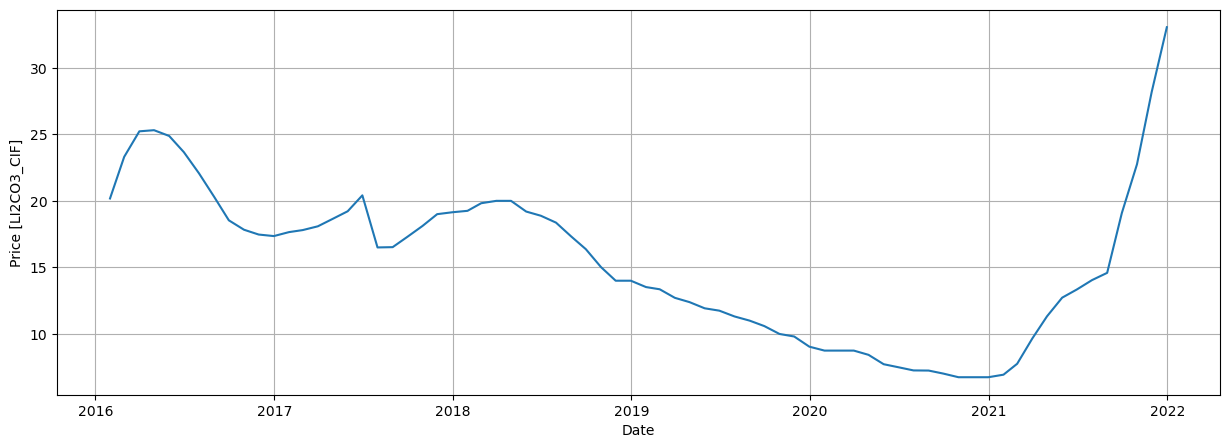

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df_2021['ds'], df_2021['y'])
plt.xlabel('Date')
plt.ylabel('Price [LI2CO3_CIF]')
plt.grid()

In [8]:
# Y_train_df = df_combined[df_combined.ds<='2021-12-31']
# Y_test_df = df_combined[df_combined.ds>'2021-12-31']

# Fit and predict with N-BEATS and N-HiTS models
# horizon = len(Y_test_df)

In [9]:
# nhits_config = {
#        "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
#        "max_steps": tune.choice([1000]),                                         # Number of SGD steps
#        "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
#        "batch_size": tune.choice([7]),                                           # Number of series in windows
#        "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
#        "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
#        "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
#        "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
#        "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
#        "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
#        "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
#        "random_seed": tune.randint(1, 10),
#        "scaler_type": tune.choice(['robust']),
#        "check_val_every_n_epoch": tune.choice([100])
#     }

In [19]:
horizon = 12
models = [
          # LSTM(h=horizon,                    
          #      gpus=1,
          #      max_epochs=500,
          #      hist_exog_list = df_combined.columns[4:].values.flatten().tolist(),
          #      futr_exog_list = df2.columns[2:].values.flatten().tolist(),
          #      # hist_exog_list = df.columns[4:].values.flatten().tolist(),
          #      scaler_type='robust',       # Type of scaler to normalize data
          #      encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
          #      decoder_hidden_size=64,),
          # AutoTFT(h=horizon,
          #         gpus=1,
          #         loss=MAE(),
          #         config=None,
          #         # futr_exog_list = df2.columns[2:].values.flatten().tolist(),
          #         # hist_exog_list = df_combined.columns[1:].values.flatten().tolist(),
          #         num_samples=12),
            NBEATS(input_size=2 * horizon, gpus = 1, h=horizon, 
                   futr_exog_list = [
                  'Shanghai Containerized Freight Index (SCFI)'
                  # '대두 [미국(생산자 가격)] 현물',
                  # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
                  '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물'
                  'HOUSECOST_KOR'
                 ],
                   max_epochs=100),      
            NHITS(h = horizon,
                        gpus=1,
                        input_size = 2*horizon,
                        hist_exog_list = df_combined_2021.columns[4:].values.flatten().tolist(),
                        futr_exog_list = [
                                          'Shanghai Containerized Freight Index (SCFI)'
                                          # '대두 [미국(생산자 가격)] 현물',
                                          # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
                                          '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물'
                                          'HOUSECOST_KOR'
                                         ],
                        # hist_exog_list = df.columns[4:].values.flatten().tolist(),
                        max_steps=100,
                        # stat_exog_list =
                        scaler_type = 'standard'
                        )]

In [20]:
df_combined_2021.columns[4:].values.flatten().tolist(),

(['미국 생산자물가지수',
  '광물종합지수',
  '원면 [브라질(수출가 FOB)] 현물',
  '옥수수 For Grain [미국(생산자 가격)] 현물',
  '커피 Arabicas [미국/유럽] 현물',
  'WTI [CME(NYMEX)] 2022.12',
  '미국 소비자물가지수',
  '대두유 crude and refined average price [파라나구아(FOB)] 현물',
  '대두 [미국(생산자 가격)] 현물',
  '미국 근원소비자물가지수',
  '탄화규소 88% 0-10mm [중국(FOB)] 현물',
  '소맥 Durum [미국(생산자 가격)] 현물',
  'Howe Robinson Container Index',
  '대두박 [파라나구아(FOB)] 현물',
  '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
  'GDP_SAU',
  'HOUSECOST_KOR',
  'PPP_POL',
  'PPP_SRB'],)

In [21]:
%%time
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=df_2021, static_df=static_df)

Epoch 0:  50%|███████████████▌               | 1/2 [00:00<00:00, 14.59it/s, loss=3.4, v_num=576, train_loss_step=3.400]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███   | 1/2 [00:00<00:00, 19.89it/s, loss=7.54, v_num=576, train_loss_step=11.70, train_loss_epoch=3.400]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███   | 1/2 [00:00<00:00, 20.19it/s, loss=6.27, v_num=576, train_loss_step=3.730, train_loss_epoch=11.70]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███   | 1/2 [00:00<00:00, 20.60it/s, loss=5.77, v_num=576, train_loss_step=4.300, train_loss_epoch=3.730]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███   | 1/2 [00:00<00:00, 21.73it/s, loss=5.29, v_num=576, train_loss_step=3.360, train_loss_epoch=4.300]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███   | 1/2 [00:00<00:00, 22.14it/s, loss=4.92, v_num=576, train_loss_step=3.070, train_loss_epoch=3.360]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███   | 1/2 [00:00<00:00, 18.20it/s, loss=4.61, v_num=576, train_loss_step=2.750

In [22]:
futr_df = pd.read_csv('./data/metal_ftr_2022.csv')
futr_df.rename(columns={'date':'ds'},inplace=True)
futr_df['ds'] = pd.to_datetime(futr_df['ds'], format='%Y-%m-%d')

Y_hat_df = nf.predict(futr_df=futr_df)
Y_hat_df

Y_hat_df.to_csv('NHITS_test.csv')
Y_hat_df

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.38it/s]


,ds,NBEATS,NHITS
unique_id,,,
A,2022-01-31,40.789738,36.436775
A,2022-02-28,43.446026,41.450287
A,2022-03-31,49.007538,46.151699
A,2022-04-30,55.241726,49.664970
A,2022-05-31,49.771263,50.152931
A,2022-06-30,45.389359,51.215210
A,2022-07-31,41.298946,49.943066
A,2022-08-31,39.249420,46.392616
A,2022-09-30,31.990728,41.833359


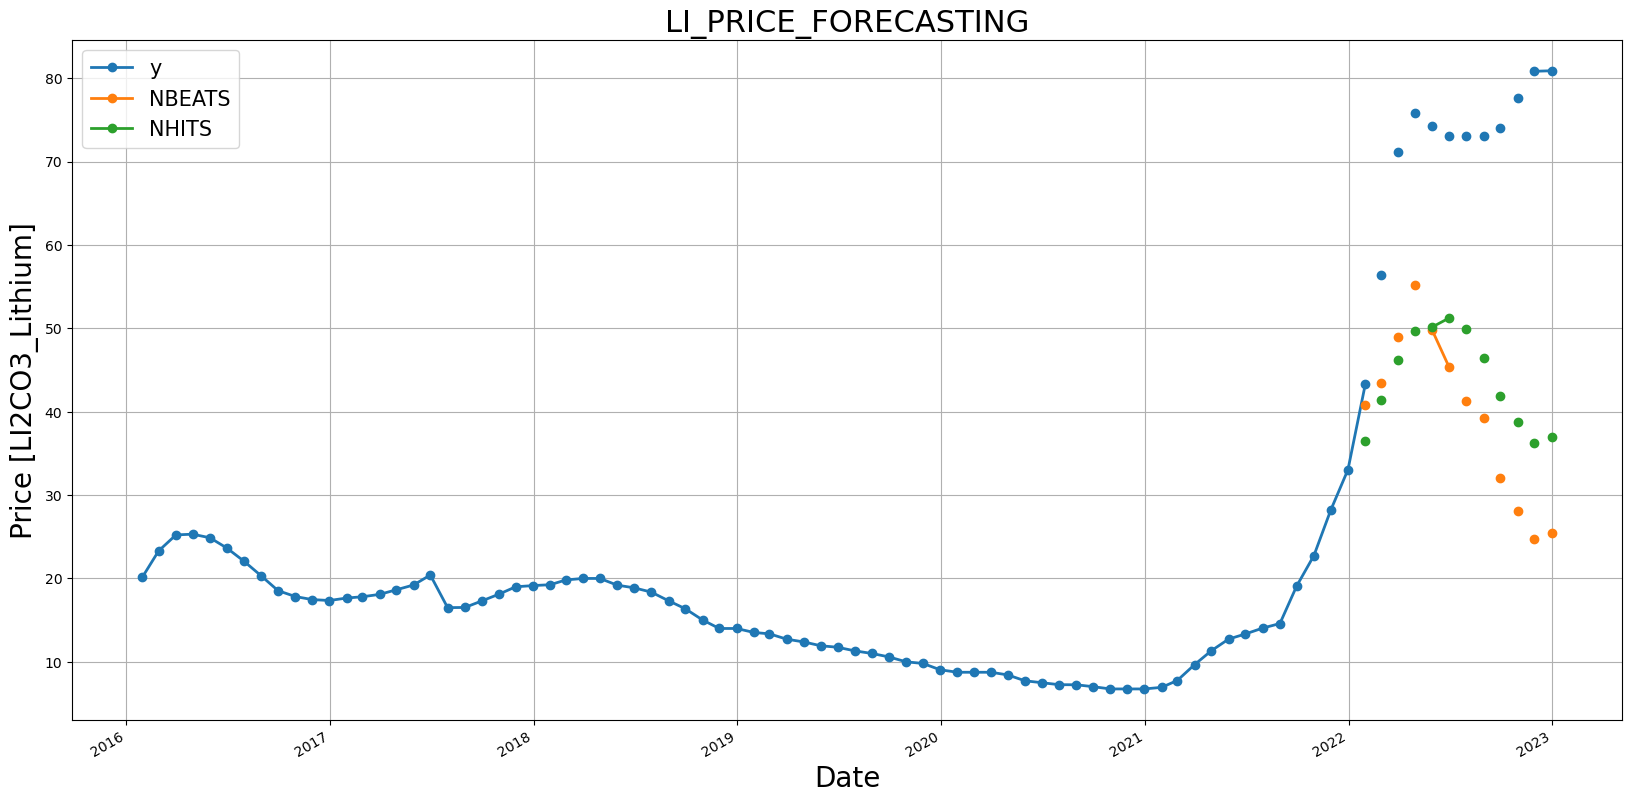

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
plot_df = df_2022.reset_index(drop=True)
plot_df2 = pd.concat([plot_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df2[['y', 'NBEATS','NHITS']].plot(ax=ax, linewidth=2, marker = 'o')

ax.set_title('LI_PRICE_FORECASTING', fontsize=22)
ax.set_ylabel('Price [LI2CO3_Lithium]', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [298]:
NHITS_HAT = plot_df2[plot_df2.index>='2022-01-01']['NHITS']
NHITS_HAT = NHITS_HAT.reset_index(drop=True)
Y_HAT = df_2022[df_2022.ds>='2022-01-01']['y']
Y_HAT.reset_index(drop=True,inplace=True)
print('Accuracy by MAPE: ', 100 - ((mape(NHITS_HAT, Y_HAT)) * 100))

Accuracy by MAPE:  100.0


In [293]:
NHITS_HAT

0     37.033661
1     44.222996
2     48.503769
3     52.853710
4     53.525040
5     51.103600
6     48.882153
7     45.144535
8     39.752705
9     34.957687
10    33.834076
11    33.967583
Name: NHITS, dtype: float64

In [294]:
Y_HAT

0     43.260870
1     56.425000
2     71.086957
3     75.804348
4     74.295455
5     73.000000
6     73.000000
7     73.000000
8     74.047619
9     77.673913
10    80.818182
11    80.882353
Name: y, dtype: float64